# <center>Incremental Clustering

In [45]:
##import section
import random
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings

warnings.filterwarnings('ignore')

In [46]:
##Generate random point from random cluster
def generatePointFromRandomCluster():
    op=[(0, 0, 10),(0, 50, 15),(50, 0, 15),(0,-50, 15),
    (-50, 0, 15),(70,-70, 20),(-70,70, 20),(-70, -70, 20),(70,70,20),(35, 35, 15),
    (35, -35, 15),(-35, 35, 15),(-35, -35, 15)]
    pick=random.choice(op)
    cx,cy,radius=pick[0],pick[1],pick[2]
    r=random.uniform(0,radius)
    t=random.uniform(0,2*math.pi)
    xt=r*math.cos(t)+cx
    yt=r*math.sin(t)+cy
    return xt,yt

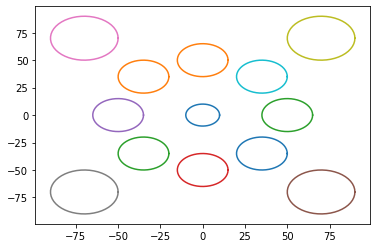

In [47]:
def actualclusters():
    op=[(0, 0, 10),(0, 50, 15),(50, 0, 15),(0,-50, 15),
        (-50, 0, 15), (70,-70, 20),(-70,70, 20), (-70, -70, 20), (70,70,20),(35, 35, 15),
        (35, -35, 15),(-35, 35, 15),(-35, -35, 15)]
    plt.figure()
    for i in op:
        x, y, r = i[0], i[1], i[2]
        t= np.linspace(0,2*math.pi)
        plt.plot(r*np.cos(t) + x, r*np.sin(t) + y)
        
actualclusters()

In [81]:
##intialization
mx1, my1 = generatePointFromRandomCluster()
vx1 = 10
vy1 = 10
pi1 = 1
default_cov = np.array([1/vx1,0,0,1/vy1]).reshape(2,2)
clusters = np.array([mx1, my1, vx1, vy1, pi1]).reshape(1,5)
points = [np.array([mx1, my1]).reshape(1,2)]
lambd = 2
alpha = 0.3
itr = 1000
maxclusters= 25
#mahalanobis threshold for merging
threshold = 15

In [82]:
##plotting the clusters
def plotclusters(clusters, points):
    fig, ax = plt.subplots()
    th=np.linspace(0,2*math.pi)
    for q in range(len(clusters)):
        a = clusters[q][2]
        b = clusters[q][3]
        ax.scatter(points[q][:,0], points[q][:,1])
        ax.plot(a*np.cos(th) + clusters[q][0], b*np.sin(th) + clusters[q][1])
        ax.annotate(str(q),(np.mean(points[q][:,0]), np.mean(points[q][:,1])) )
    plt.show()

In [83]:
##function to merge clusters based on mahalanobis distance
def mergeclusters(clusters, points):
       #D is mahalanobis distance matrix
    D = np.zeros(len(clusters)**2).reshape(len(clusters),len(clusters))
    for i in range(len(clusters)):
        c1 = 0
           #computing inverse of covariance matrix of clusters and if singular matrices or single point clustsers exist
           #use default covariance matrix
        if np.linalg.det(np.cov(points[i].T)) >= 0.001 and points[i].shape[0]!=1:
            c1 = np.linalg.inv(np.cov(points[i].T))
        else:
            c1 = default_cov
        for j in range(i+1,len(clusters)):
            c2 = 0
            if np.linalg.det(np.cov(points[j].T)) >= 0.001 and points[j].shape[0]!=1:
                c2 = np.linalg.inv(np.cov(points[j].T))
            else:
                c2 = default_cov
            D[i][j] = (0.5)*np.dot(np.dot((clusters[i][0:2] - clusters[j][0:2]).T.reshape(1,2),(c1 + c2)),(clusters[i][0:2] - clusters[j][0:2]).reshape(2,1))
            D[j][i] = D[i][j]
    temp = D
    temp[temp==0] = 'inf'
    if np.min(temp) <= threshold:
        f, g = np.where(temp == np.min(temp))
        i = f[0]
        k = f[1]
           #mean_update
        clusters[i][0:2] = clusters[i][0:2]*clusters[i][4] +  clusters[k][0:2]*clusters[k][4]
        clusters[i][0:2] = clusters[i][0:2]/(clusters[i][4] + clusters[k][4])
           #variance_update
        clusters[i][2:4] = clusters[i][2:4]*clusters[i][4] +  clusters[k][2:4]*clusters[k][4]
        if clusters[i][2] < vx1:
            clusters[i][2] = vx1
        if clusters[i][3] < vy1:
            clusters[i][3] = vy1
           #pi_update
        clusters[i][4] = clusters[i][4] + clusters[k][4]
        points[i] = np.append(points[i], points[k])
        points[i] = points[i].reshape(int(points[i].shape[0]/2), 2)
        clusters = np.delete(clusters, k, axis = 0) 
        del points[k]
        mdel = np.array([i,k]) 
        return clusters, points, mdel
    else:
           #if no clusters have intermahalanobis distance lesser than the threshold delete cluster with least pi
        del_index = np.argmin(clusters[:,4]) 
        pp = clusters[del_index][4]
        clusters = np.delete(clusters, del_index, axis = 0)  
        del points[del_index]
        mdel = del_index
        #recalculating pi for all clusters
        clusters[:,4] = clusters[:,4] + (pp/(maxclusters))
        return clusters, points, mdel       

affected cluster 5


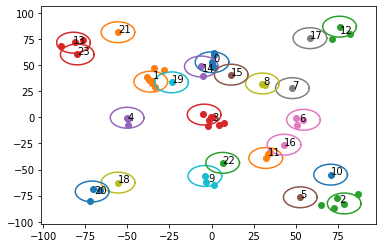

affected cluster [ 3 14]


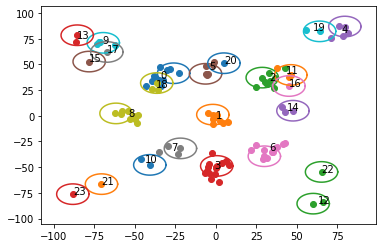

affected cluster 0


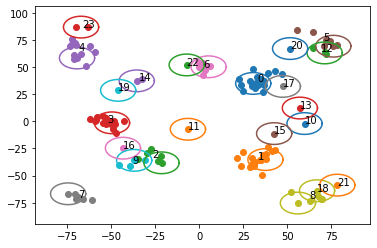

affected cluster 8


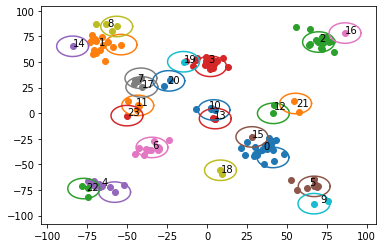

affected cluster 6


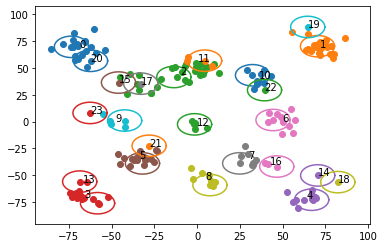

affected cluster [ 8 24]


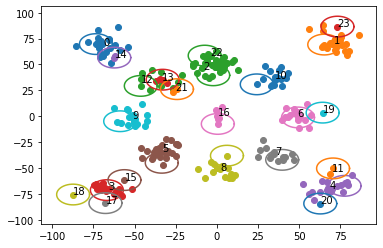

affected cluster [ 0 23]


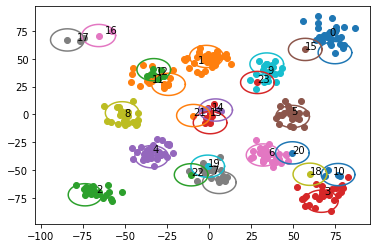

affected cluster [ 8 17]


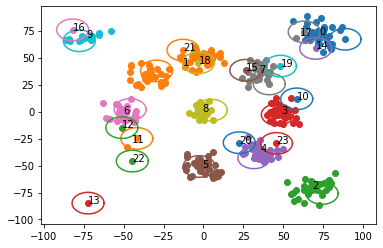

affected cluster [ 3 18]


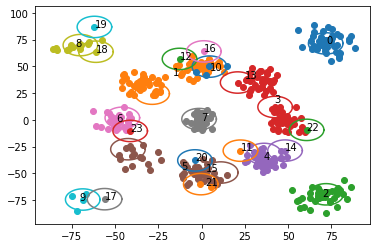

affected cluster 10


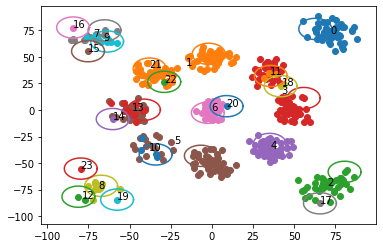

In [84]:
#Incremental kmeans        
for t in range(itr):
    xt,yt = generatePointFromRandomCluster()
    #Point to Centroids distances
    mean_distances = np.divide((xt - clusters[:,0])**2, clusters[:,2]) + np.divide((yt - clusters[:,1])**2, clusters[:,3])
   
    chebyshev_distances = (lambd**2) - (mean_distances)


    #new cluster - increment!
    if chebyshev_distances[chebyshev_distances>=0].shape[0] == 0:
        clusters[:,4] = (1- alpha)*clusters[:,4]
        clusters = np.append(clusters, np.array([xt, yt, vx1, vy1, alpha]).reshape(1, 5)).reshape(clusters.shape[0] + 1, 5)
        points.append(np.array([xt,yt]).reshape(1,2))
        #invoke merge method!
        if clusters.shape[0] > maxclusters:
            clusters, points, mdel = mergeclusters(clusters, points)
    #point belongs to exisitng cluster
    else:
        p_index = list(chebyshev_distances).index(min(chebyshev_distances[chebyshev_distances>0]))
        points[p_index] = np.vstack((points[p_index],np.array([xt,yt])))
        #update these clusters alone 
        upd = np.where(chebyshev_distances>=0)
        mems = np.exp((-1/2)*mean_distances[upd])
        s_mems = sum(mems)
        beta_r = mems / s_mems
        alpha_r = alpha*beta_r
#       piupdate
        clusters[upd][:,4] = (1- alpha)*clusters[upd][:,4] + alpha_r
#       varianceupdate
        clusters[upd][:,2] = (1 - beta_r)*(clusters[upd][:,2] + beta_r*(xt - clusters[upd][:,0])**2)
        clusters[upd][:,3] = (1 - beta_r)*(clusters[upd][:,3] + beta_r*(yt - clusters[upd][:,1])**2)
        for i in upd[0].tolist():
            if clusters[i][2] < vx1:
                clusters[i][2] = vx1
            if clusters[i][3] < vy1:
                clusters[i][3] = vy1
#       meanupdate
        clusters[upd][:,0] = (1 - beta_r)*clusters[upd][:,0] + beta_r*xt
        clusters[upd][:,1] = (1 - beta_r)*clusters[upd][:,1] + beta_r*yt 
   
    if (t+1) % 100 == 0:                                                
        clusters, points, mdel = mergeclusters(clusters, points)
        print("affected cluster", mdel)
        plotclusters(clusters, points)  
    